# Stage 3 - Project Work

***MEIN40420 - Internship Research Project - 2024/25 Summer***

> - **Programmer:** Yu Du
> - **Last Update:** Aug. 12<sup>th</sup>, 2025

**Keywords:** **Proteomics**, **TCR**, **PD1**

The required runtime environment can be set up using the following commands:
```bash
conda create -n irp-lab-env python=3.10 -y
conda activate irp-lab-env
pip install numpy pandas matplotlib scipy statsmodels gseapy networkx scikit-learn seaborn scanpy anndata
```

**Contents**
- [Data Preparation](#data-preparation)
- [Differential Analysis](#differential-analysis)
- [Enrichment Analysis](#enrichment-analysis)
- [Protein Network Pathway Analysis](#protein-network-pathway-analysis)
- [Time Dynamic Analysis](#time-dynamic-analysis)
- [Cluster Enrichment Analysis](#cluster-enrichment-analysis)

In [195]:
# Import necessary packages
import re
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gseapy as gp
import seaborn as sns

import requests
import networkx as nx

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import scanpy as sc
import anndata as ad

---

## Data Preparation

In [50]:
# ========= Data Preparation =========
# Set data file paths
meta_path = "./meta_data.csv"
protein_path = "./tp reordered.xlsx"

# Read meta data and protein abundance data
meta_df = pd.read_csv(meta_path)
protein_df = pd.read_excel(protein_path)

# Extract protein annotation and expression data
protein_metadata = protein_df.iloc[:, :10]      # First 10 columns are metadata
expression_data = protein_df.iloc[:, 10:66]     # Extract PD1 positive part from column 11 to 65 

# Get IDs from the first row of expression data and protein metadata (row 0)
metasample_ids = protein_metadata.iloc[0, :].tolist()
sample_ids = expression_data.iloc[0, :].tolist()

# Assign these IDs as column names
protein_metadata.columns = metasample_ids
expression_data.columns = sample_ids

# Drop the first row (which contained IDs)
protein_metadata = protein_metadata.drop(index=0)
expression_data = expression_data.drop(index=0)

# Reset index for clarity
protein_metadata.reset_index(drop=True, inplace=True)
expression_data.reset_index(drop=True, inplace=True)

# Attach gene names for future reference
expression_data.insert(0, "Gene", protein_metadata.iloc[:, 3].values)

# Drop empty columns if any
expression_data = expression_data.loc[:, ~expression_data.columns.duplicated()]

# Filter out only columns with valid sample IDs (match with meta_df)
valid_sample_ids = meta_df["sample_id"].str.strip().tolist()
expression_data = expression_data.loc[:, ["Gene"] + [col for col in expression_data.columns if col in valid_sample_ids]]

# Ensure data types are numeric
for col in expression_data.columns[1:]:
    expression_data[col] = pd.to_numeric(expression_data[col], errors='coerce')

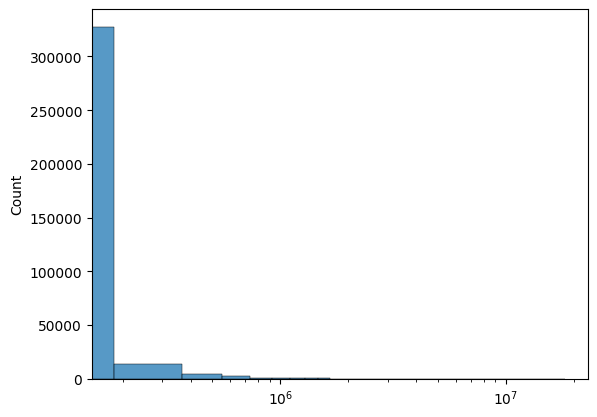

In [51]:
# ========= Low Abundance Proteins Filter =========
# Visually examine the abundance distribution to select a cutoff point between detection noise for low-abundance proteins and true signal for high-abundance proteins
sns.histplot(expression_data.iloc[:, 1:].stack(), bins=100)
plt.xscale('log')
plt.show()

In [ ]:
# Coverage filtering: retain proteins with quantitative values in at least half of the samples
coverage_threshold = expression_data.shape[1] // 2
mask_coverage = (expression_data.iloc[:, 1:] > 0).sum(axis=1) >= coverage_threshold

# Abundance filtering: remove proteins with a mean value below the threshold of 1e5
mask_abundance = expression_data.iloc[:, 1:].mean(axis=1) >= 1e5

# Apply both above
filtered_data = expression_data[mask_coverage & mask_abundance]
print(filtered_data.shape)

(866, 57)


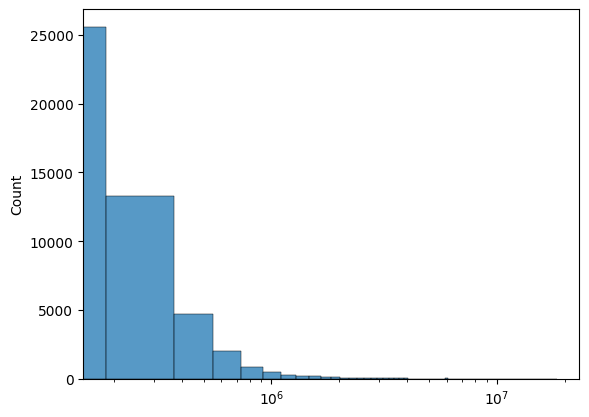

In [53]:
# Examine again
sns.histplot(filtered_data.iloc[:, 1:].stack(), bins=100)
plt.xscale('log')
plt.show()

In [ ]:
# ========= Batch Correction =========
# Set Gene as the row index and other columns as sample columns
expr = filtered_data.rename(columns={filtered_data.columns[0]: "Gene"}).set_index("Gene").copy()

# Parse batch from column name (letters A-D are used as batch labels). 
# For example: "...ProtA2_S3_A10_... MaxLFQ Intensity" -> batch = "A"
def extract_batch(s):
    m = re.search(r"Prot([A-D])\d", s)
    return m.group(1) if m else np.nan

# Extract batch
meta = meta_df.copy()
meta["batch"] = meta["sample_id"].apply(extract_batch)

# Find the intersection and align the order (based on the meta order to avoid missing samples/misalignment)
common_ids = meta["sample_id"].isin(expr.columns)
meta = meta.loc[common_ids].copy()

expr = expr.loc[:, expr.columns.isin(meta["sample_id"])].copy()

# Rearrange expression matrix columns strictly in meta order
expr = expr.reindex(columns=meta["sample_id"].tolist())

# Ensure data types are numeric
expr = expr.apply(pd.to_numeric, errors="coerce")

In [ ]:
# Convert to log2
expr_log2 = np.log2(expr + 1.0)

# Build AnnData
adata = ad.AnnData(X=expr_log2.T.copy())
adata.obs.index = meta["sample_id"].values
adata.obs["batch"] = meta["batch"].astype(str).values

# Batch calibration
sc.pp.combat(adata, key="batch")

# Get back the corrected matrix (still in log2 dimension)
expr_corrected_log2 = pd.DataFrame(adata.X.T, index=expr.index, columns=expr.columns)
expr_corrected_log2.to_csv("./expression_batch_corrected_log2.csv")

/opt/miniconda3/envs/irp-lab-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


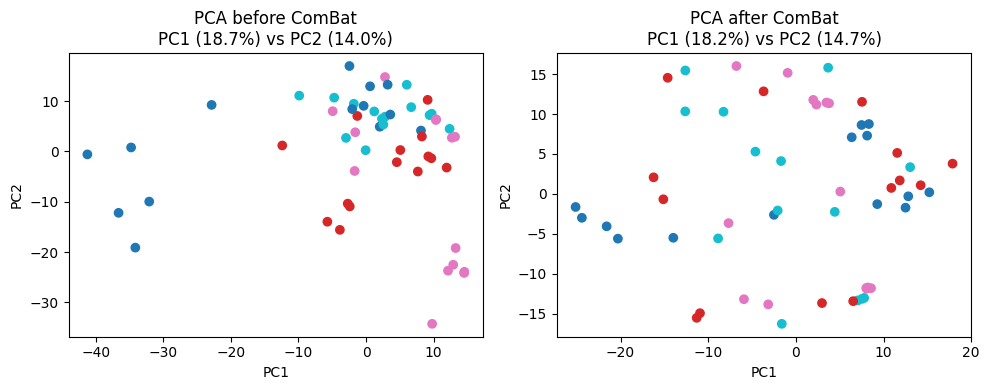

In [89]:
# Use PCA to check the effect
pca_before = PCA(n_components=2)
pca_result_before = pca_before.fit_transform(expr_log2.T)

pca_after = PCA(n_components=2)
pca_result_after = pca_after.fit_transform(expr_corrected_log2.T)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sc1 = axes[0].scatter(pca_result_before[:, 0], pca_result_before[:, 1],
                      c=meta["batch"].astype('category').cat.codes, cmap='tab10')
axes[0].set_title(f"PCA before ComBat\nPC1 ({pca_before.explained_variance_ratio_[0]*100:.1f}%) vs "
                  f"PC2 ({pca_before.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

sc2 = axes[1].scatter(pca_result_after[:, 0], pca_result_after[:, 1],
                      c=meta["batch"].astype('category').cat.codes, cmap='tab10')
axes[1].set_title(f"PCA after ComBat\nPC1 ({pca_after.explained_variance_ratio_[0]*100:.1f}%) vs "
                  f"PC2 ({pca_after.explained_variance_ratio_[1]*100:.1f}%)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

## Differential Analysis

In [132]:
# ========= Differential Analysis of TCS (TCR) vs TCS+PDL1 (TCR + PD1) Conditions =========
# Define the difference analysis function
def differential_analysis(expression_data, meta_data, cells="PD_1", time="5 min", condition1_pdl1="TCS Ctrl", condition2_pdl1="TCS PDL1"):

    # Screen samples based on the paramters
    meta = meta_data[
        (meta_data["cells"].str.strip() == cells) &
        (meta_data["time"].str.strip() == time)
    ]

    # Group samples
    group_ctrl = meta[meta["pdl1"].str.strip() == condition1_pdl1]["sample_id"].tolist()
    group_pdl1 = meta[meta["pdl1"].str.strip() == condition2_pdl1]["sample_id"].tolist()

    # Extract expression matrix
    expr_ctrl = expression_data[["Gene"] + group_ctrl].set_index("Gene")
    expr_pdl1 = expression_data[["Gene"] + group_pdl1].set_index("Gene")

    # Make sure both groups use the same protein order (row order)
    expr_ctrl = expr_ctrl.loc[expr_ctrl.index.isin(expr_pdl1.index)]
    expr_pdl1 = expr_pdl1.loc[expr_pdl1.index.isin(expr_ctrl.index)]

    # Perform t-test for each protein
    p_values, log2fc, genes = [], [], expression_data.index.tolist()

    for gene in expr_ctrl.index:
        ctrl_vals = expr_ctrl.loc[gene].dropna()
        pdl1_vals = expr_pdl1.loc[gene].dropna()

        if len(ctrl_vals) > 1 and len(pdl1_vals) > 1:
            stat, pval = ttest_ind(ctrl_vals, pdl1_vals, equal_var=False)
            p_values.append(pval)

            # log2 fold change: mean(PDL1) - mean(Ctrl)
            log2fc.append(pdl1_vals.mean() - ctrl_vals.mean())
        else:
            p_values.append(np.nan)
            log2fc.append(np.nan)

    # Generate a table of difference analysis results
    results_df = pd.DataFrame({
        "Gene": expr_ctrl.index,
        "log2FC": log2fc,
        "p_value": p_values
    })

    results_df["log2FC"] = pd.to_numeric(results_df["log2FC"], errors="coerce")
    results_df["p_value"] = pd.to_numeric(results_df["p_value"], errors="coerce")

    # Remove missing values
    results_df = results_df.dropna(subset=["log2FC", "p_value"])

    # Add FDR-corrected p-values
    results_df["p_adj"] = multipletests(results_df["p_value"], method="fdr_bh")[1]

    # Add significance markers (p < 0.05 and |log2FC| > 1)
    results_df["significant"] = (results_df["p_value"] < 0.05) & (results_df["log2FC"].abs() > 1)
    results_df["significant_fdr"] = (results_df["p_adj"] < 0.1) & (results_df["log2FC"].abs() > 0.5)

    return results_df

# Define Volcano Plot Analysis
def volcano_plot_analysis(results_df, time="5 min"):

    # Data needed to create a volcano plot
    results_df["-log10(p-value)"] = -np.log10(results_df["p_value"])
    results_df["-log10(p_adj)"] = -np.log10(results_df["p_adj"].replace(0, 1e-300))

    # Draw volcano plots (side-by-side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Raw p-value volcano
    axes[0].scatter(results_df["log2FC"], results_df["-log10(p-value)"],
                    c=results_df["significant"].map({True: "red", False: "gray"}),
                    alpha=0.7)
    axes[0].axhline(-np.log10(0.05), color="blue", linestyle="--", linewidth=1)
    axes[0].axvline(-1, color="green", linestyle="--", linewidth=1)
    axes[0].axvline(1, color="green", linestyle="--", linewidth=1)
    axes[0].set_title("Raw p-value", fontsize=14)
    axes[0].set_xlabel("log2 Fold Change", fontsize=12)
    axes[0].set_ylabel("-log10(p-value)", fontsize=12)
    axes[0].grid(True)

    # FDR-adjusted volcano
    axes[1].scatter(results_df["log2FC"], results_df["-log10(p_adj)"],
                c=results_df["significant_fdr"].map({True: "red", False: "gray"}),
                alpha=0.7)
    axes[1].axhline(-np.log10(0.1), color="blue", linestyle="--", linewidth=1)
    axes[1].axvline(-1, color="green", linestyle="--", linewidth=1)
    axes[1].axvline(1, color="green", linestyle="--", linewidth=1)
    axes[1].set_title("FDR-adjusted p-value", fontsize=14)
    axes[1].set_xlabel("log2 Fold Change", fontsize=12)
    axes[1].grid(True)

    plt.suptitle("Volcano Plots: PD-1 Activation vs TCR Alone (" + time + ")", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [168]:
# Read preprocessed data
expression_path = "./expression_batch_corrected_log2.csv"
expression_data = pd.read_csv(expression_path)

In [169]:
# Run the analysis and print the results of the analysis for the significant
results_df_5min = differential_analysis(expression_data=expression_data, meta_data=meta_df)
print("PD-1 differential expression analysis results at 5 minutes:\n")
print("* Raw results of the analysis for the significant:\n", results_df_5min[results_df_5min["significant"] == True])
print("\n* FDR-adjusted results of the analysis for the significant:\n", results_df_5min[results_df_5min["significant_fdr"] == True])

PD-1 differential expression analysis results at 5 minutes:

* Raw results of the analysis for the significant:
         Gene    log2FC   p_value     p_adj  significant  significant_fdr
91       HBD  1.280813  0.027588  0.302265         True            False
678  H2BC20P  1.054395  0.009125  0.172667         True            False
709   CACTIN -1.753526  0.034512  0.316595         True            False
710  HNRNPLL  1.109003  0.046125  0.338037         True            False
718    SORL1  8.523220  0.015914  0.220235         True            False

* FDR-adjusted results of the analysis for the significant:
        Gene    log2FC       p_value     p_adj  significant  significant_fdr
89      PLG  0.711470  3.208624e-07  0.000275        False             True
538    HBA2  0.756645  2.316147e-03  0.090330        False             True
567   EWSR1  0.604877  1.984698e-04  0.028381        False             True
696  H2AC21  0.522384  4.563856e-04  0.043509        False             True


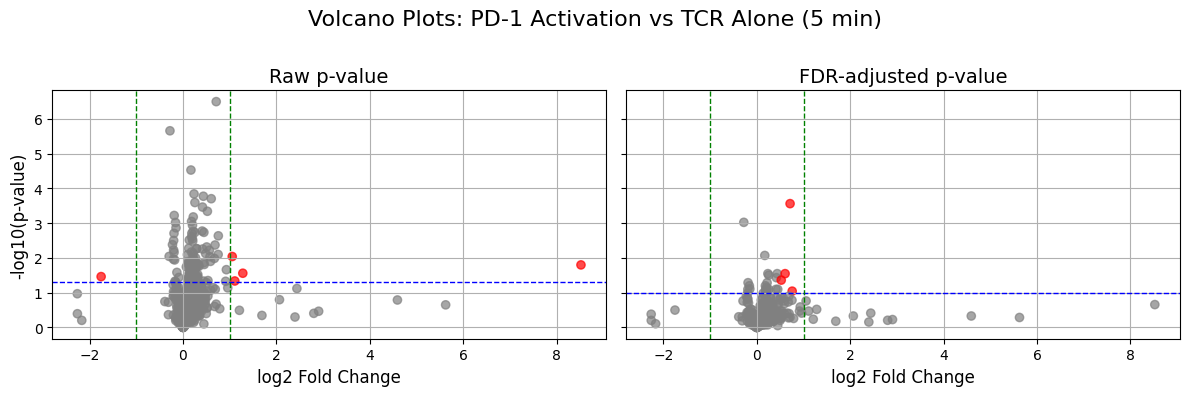

In [170]:
# Draw a volcano plot for alignment analysis
volcano_plot_analysis(results_df=results_df_5min)

In [172]:
# Run the analysis and print the results of the analysis for the significant
results_df_20min = differential_analysis(expression_data=expression_data, meta_data=meta_df, time="20 min")
print("PD-1 differential expression analysis results at 20 minutes:\n")
print("* Raw results of the analysis for the significant:\n", results_df_20min[results_df_20min["significant"] == True])
print("\n* FDR-adjusted results of the analysis for the significant:\n", results_df_20min[results_df_20min["significant_fdr"] == True])

PD-1 differential expression analysis results at 20 minutes:

* Raw results of the analysis for the significant:
        Gene     log2FC   p_value     p_adj  significant  significant_fdr
676  BLTP3A   8.582152  0.042765  0.999245         True            False
778    LNPK  13.279522  0.000334  0.220882         True            False

* FDR-adjusted results of the analysis for the significant:
 Empty DataFrame
Columns: [Gene, log2FC, p_value, p_adj, significant, significant_fdr]
Index: []


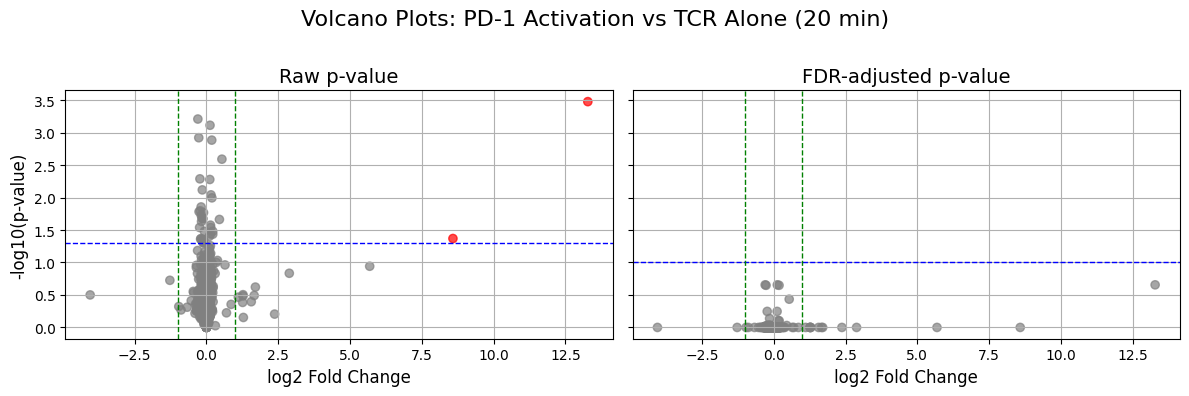

In [173]:
# Draw a volcano plot for alignment analysis
volcano_plot_analysis(results_df=results_df_20min, time="20 min")

In [174]:
# Run the analysis and print the results of the analysis for the significant
results_df_4h = differential_analysis(expression_data=expression_data, meta_data=meta_df, time="4h")
print("PD-1 differential expression analysis results at 4 hours:\n")
print("* Raw results of the analysis for the significant:\n", results_df_4h[results_df_4h["significant"] == True])
print("\n* FDR-adjusted results of the analysis for the significant:\n", results_df_4h[results_df_4h["significant_fdr"] == True])

PD-1 differential expression analysis results at 4 hours:

* Raw results of the analysis for the significant:
         Gene    log2FC   p_value     p_adj  significant  significant_fdr
107    RPLP1 -1.154676  0.030370  0.129047         True            False
319    RPL22 -1.016386  0.003224  0.084105         True             True
511     PPIA -1.354881  0.032150  0.130218         True            False
710  HNRNPLL -1.227180  0.034123  0.130401         True            False

* FDR-adjusted results of the analysis for the significant:
        Gene    log2FC   p_value     p_adj  significant  significant_fdr
55       CS -0.680089  0.009082  0.099548        False             True
221    BTF3 -0.678182  0.006521  0.098156        False             True
319   RPL22 -1.016386  0.003224  0.084105         True             True
436    EIF6 -0.581524  0.006064  0.097355        False             True
568  RPL18A -0.735131  0.001092  0.079659        False             True
829   NUDT5 -0.575841  0.00939

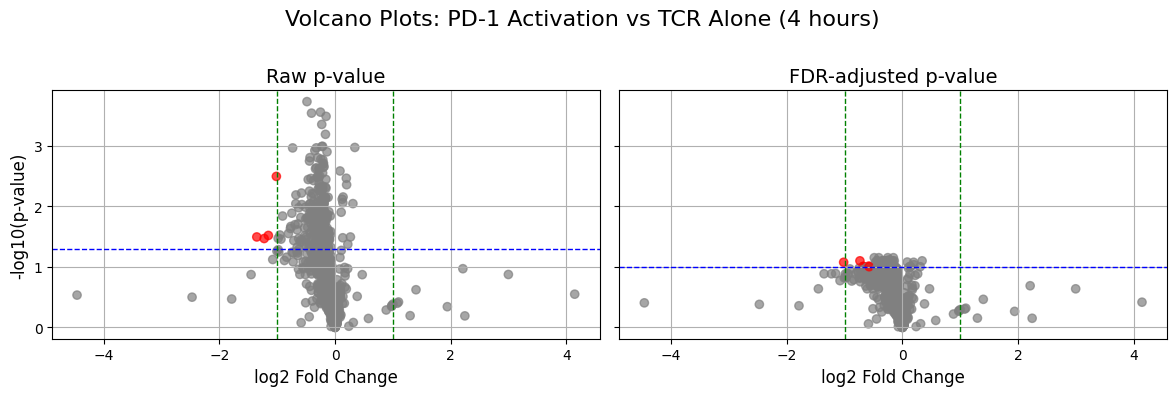

In [175]:
# Draw a volcano plot for alignment analysis
volcano_plot_analysis(results_df=results_df_4h, time="4 hours")

In [176]:
# ========= Analysis of Negative Regulatory Proteins under the Influence of PD-1 =========
downregulated_df_5min = results_df_5min[(results_df_5min["log2FC"] < -1) & (results_df_5min["p_value"] < 0.05)]
downregulated_df_5min.to_csv("./downregulated_5min.csv")
print("* 5 minutes down-regulation of significant proteins:\n", downregulated_df_5min)

* 5 minutes down-regulation of significant proteins:
        Gene    log2FC   p_value     p_adj  significant  significant_fdr  \
709  CACTIN -1.753526  0.034512  0.316595         True            False   

     -log10(p-value)  -log10(p_adj)  
709         1.462035       0.499495  


In [177]:
downregulated_df_20min = results_df_20min[(results_df_20min["log2FC"] < -1) & (results_df_20min["p_value"] < 0.05)]
downregulated_df_20min.to_csv("./downregulated_20min.csv")
print("* 20 minutes down-regulation of significant proteins:\n", downregulated_df_20min)

* 20 minutes down-regulation of significant proteins:
 Empty DataFrame
Columns: [Gene, log2FC, p_value, p_adj, significant, significant_fdr, -log10(p-value), -log10(p_adj)]
Index: []


In [178]:
downregulated_df_4h = results_df_4h[(results_df_4h["log2FC"] < -1) & (results_df_4h["p_value"] < 0.05)]
downregulated_df_4h.to_csv("./downregulated_4h.csv")
print("* 4 hours down-regulation of significant proteins:\n", downregulated_df_4h)

* 4 hours down-regulation of significant proteins:
         Gene    log2FC   p_value     p_adj  significant  significant_fdr  \
107    RPLP1 -1.154676  0.030370  0.129047         True            False   
319    RPL22 -1.016386  0.003224  0.084105         True             True   
511     PPIA -1.354881  0.032150  0.130218         True            False   
710  HNRNPLL -1.227180  0.034123  0.130401         True            False   

     -log10(p-value)  -log10(p_adj)  
107         1.517561       0.889252  
319         2.491599       1.075176  
511         1.492814       0.885329  
710         1.466954       0.884720  


## Enrichment Analysis

In [ ]:
# ========= Enrichment Analysis =========
# Define enrichment analysis function
def enrichment_analysis(results_df, time="5min", significant="significant"):

    # Extract significant genes for enrichment
    sig_genes = results_df[results_df[significant]]["Gene"].dropna().unique().tolist()

    enr = gp.enrichr(
        gene_list=sig_genes,
        gene_sets=["KEGG_2021_Human", "GO_Biological_Process_2021", "Reactome_2022"],
        organism="Human",
        outdir=None,
        cutoff=1.0  # Return all results for inspection
    )

    enr.results.to_csv("./enricher_" + significant + "_" + time + ".csv")
    print("")
    print(enr.results.head(20))

    return enr.results

In [180]:
enrich_df_5min = enrichment_analysis(results_df=results_df_5min)

                      Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0   protein retention in Golgi apparatus (GO:0045053)     1/5  0.001249   
1   negative regulation of triglyceride metabolic ...     1/6  0.001499   
2   regulation of adipose tissue development (GO:1...     1/

/opt/miniconda3/envs/irp-lab-env/lib/python3.10/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


In [181]:
enrich_fdr_df_5min = enrichment_analysis(results_df=results_df_5min, significant="significant_fdr")

                      Gene_set  \
0              KEGG_2021_Human   
1              KEGG_2021_Human   
2              KEGG_2021_Human   
3              KEGG_2021_Human   
4              KEGG_2021_Human   
5              KEGG_2021_Human   
6              KEGG_2021_Human   
7              KEGG_2021_Human   
8              KEGG_2021_Human   
9              KEGG_2021_Human   
10             KEGG_2021_Human   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0                             African trypanosomiasis    1/37  0.007380   
1                                             Malaria    1/50  0.009963   
2                 Complement and coagulation cascades    1/8

In [182]:
enrich_df_20min = enrichment_analysis(results_df=results_df_20min, time="20min")

                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   
5  GO_Biological_Process_2021   
6  GO_Biological_Process_2021   
7  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0  regulation of endoplasmic reticulum tubular ne...     1/6  0.000600   
1        cellular component maintenance (GO:0043954)    1/13  0.001300   
2  endoplasmic reticulum tubular network organiza...    1/15  0.001499   
3                      limb development (GO:0060173)    1/29  0.002898   
4  positive regulation of organelle organization ...    1/33  0.003297   
5    endoplasmic reticulum organization (GO:0007029)    1/73  0.007287   
6      endomembrane system organization (GO:0010256)   1/199  0.019801   
7                organelle organization (GO:0006996)   1/420  0.041560   

   Adjusted P-value Old P-value Old

/opt/miniconda3/envs/irp-lab-env/lib/python3.10/site-packages/gseapy/enrichr.py:689: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)


In [185]:
enrich_df_4h = enrichment_analysis(results_df=results_df_4h, time="4hour")

                      Gene_set  \
0              KEGG_2021_Human   
1              KEGG_2021_Human   
2              KEGG_2021_Human   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0                                            Ribosome   2/158  0.000368   
1                                 Coronavirus disease   2/232  0.000792   
2                                         Necroptosis   1/15

In [186]:
enrich_fdr_df_4h = enrichment_analysis(results_df=results_df_4h, time="4hour", significant="significant_fdr")

                      Gene_set  \
0              KEGG_2021_Human   
1              KEGG_2021_Human   
2              KEGG_2021_Human   
3              KEGG_2021_Human   
4              KEGG_2021_Human   
5              KEGG_2021_Human   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0                                            Ribosome   2/158  0.000911   
1                                 Coronavirus disease   2/232  0.001949   
2             Glyoxylate and dicarboxylate metabolism    1/3

## Protein Network Pathway Analysis

In [215]:
# ========= Protein Network Pathway Analysis =========
# Define protein network analysis function
def protein_network_analysis(enrich_df, credibility=0.4, add_neighbors=True, min_score=0.15):

    # Extract all gene names and remove duplicates
    all_genes = set()
    for gene_str in enrich_df["Genes"].dropna():
        genes = [g.strip() for g in gene_str.split(';')]
        all_genes.update(genes)
    gene_list = list(all_genes)

    # STRING API query settings
    string_api_url = "https://string-db.org/api"
    output_format = "tsv"
    method = "network"
    species = 9606                          # Human

    # Construct the request URL
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": species,
        "caller_identity": "protein_network_analysis",
    }
    if add_neighbors:
        params["add_nodes"] = 5

    request_url = f"{string_api_url}/{output_format}/{method}"
    
    current_threshold = credibility
    df = pd.DataFrame()
    while current_threshold >= min_score:

        # Request STRING data
        response = requests.post(request_url, data=params)
        response.raise_for_status()
        if not response.text.strip():
            print("STRING did not return any results!")
            break

        # Parse API request responses
        df = pd.read_csv(io.StringIO(response.text), sep="\t")

        # Build the network and iteratively lower the threshold for finding edges
        if {"preferredName_A", "preferredName_B", "score"} <= set(df.columns):
            df = df[df["score"] >= current_threshold]
            if not df.empty:
                break
        current_threshold -= 0.05           # Each time decrease 0.05

    # Initialize the graph
    G = nx.Graph()

    if not df.empty:
        for _, row in df.iterrows():
            G.add_edge(row["preferredName_A"], row["preferredName_B"], weight=row["score"])

    # Isolated points will also be drawn
    for gene in gene_list:
        if gene not in G.nodes:
            G.add_node(gene)

    # Draw
    plt.figure(figsize=(7, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)

    # Set nodes
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=900)
    nx.draw_networkx_labels(G, pos, font_size=9)

    # Use score to control edge width
    if G.number_of_edges() > 0:
        edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=[3*w for w in edge_weights], edge_color='gray')

    plt.title(f"STRING Protein Interaction Network\nThreshold={current_threshold:.2f}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

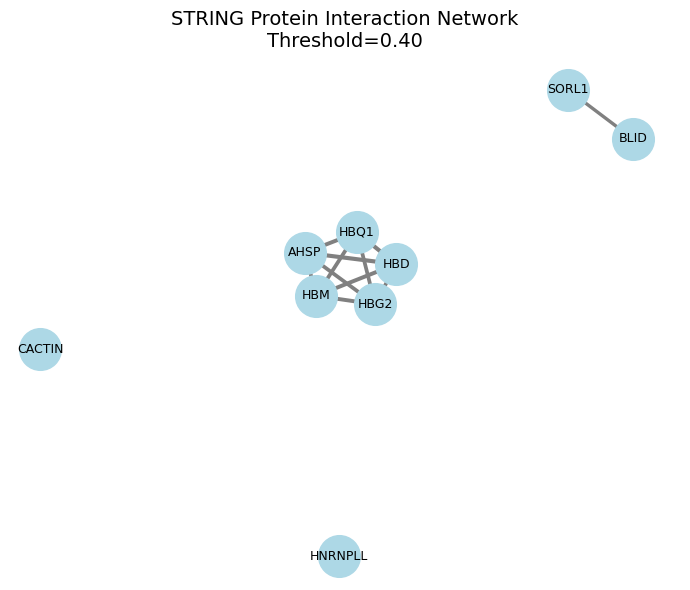

In [210]:
protein_network_analysis(enrich_df=enrich_df_5min)

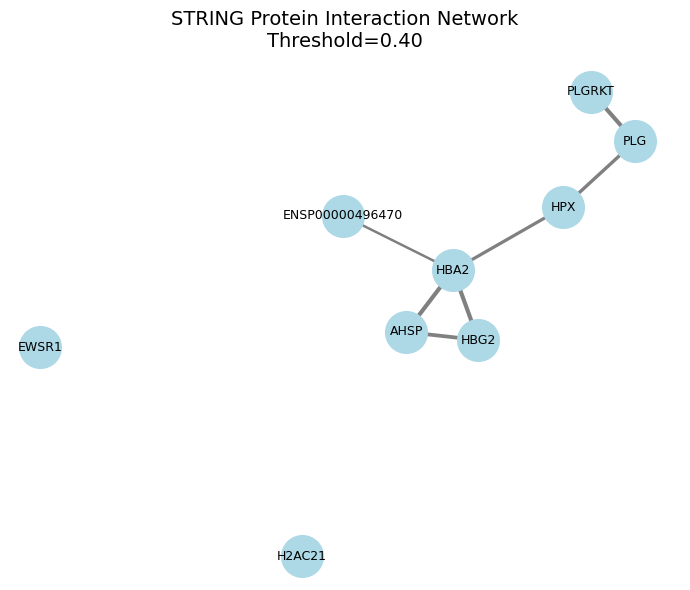

In [211]:
protein_network_analysis(enrich_df=enrich_fdr_df_5min)

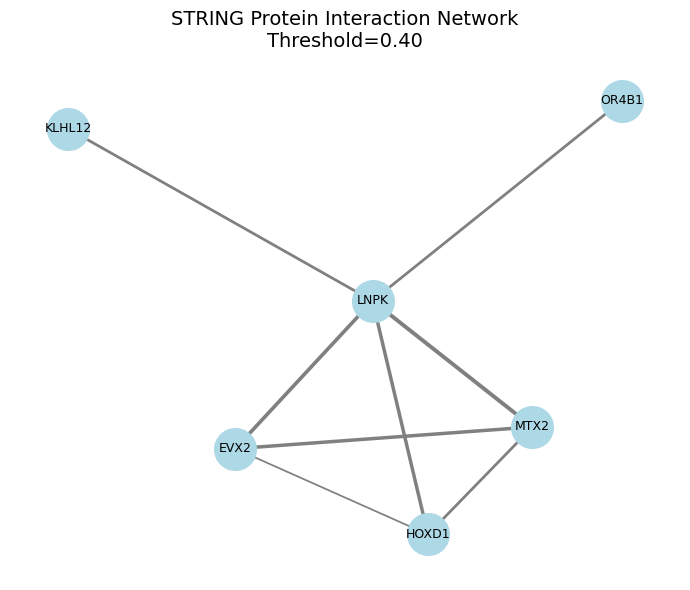

In [212]:
protein_network_analysis(enrich_df=enrich_df_20min)

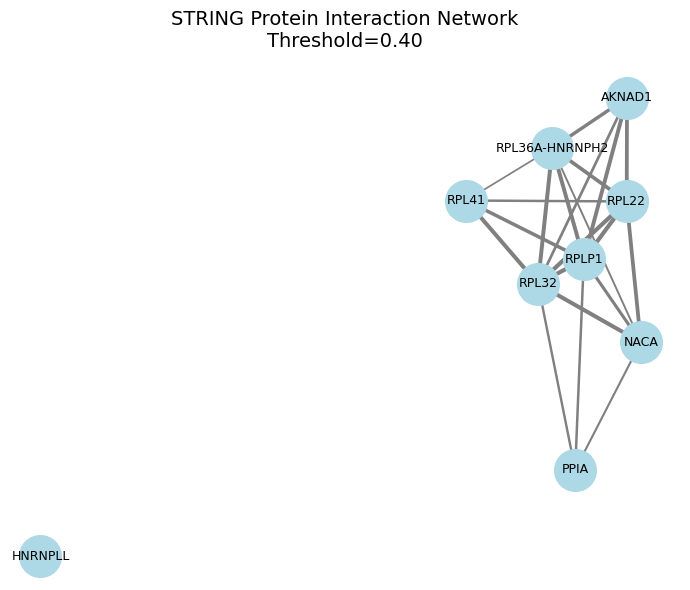

In [213]:
protein_network_analysis(enrich_df=enrich_df_4h)

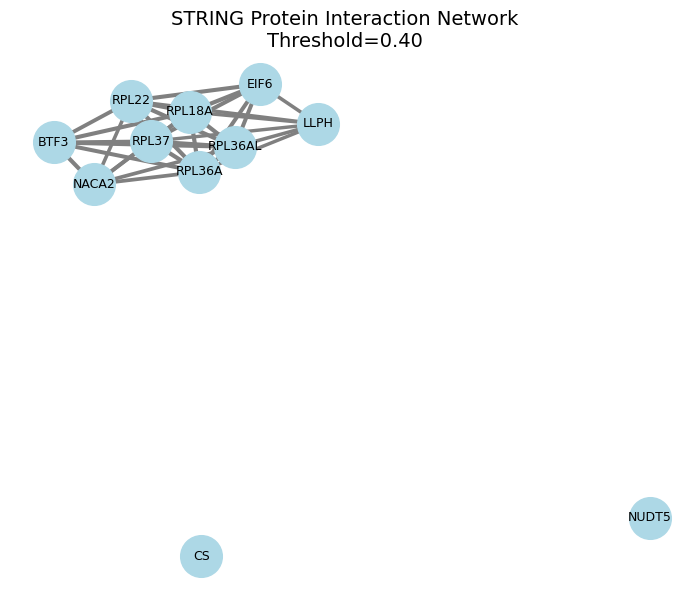

In [214]:
protein_network_analysis(enrich_df=enrich_fdr_df_4h)

## Time Dynamic Analysis

In [216]:
# ========= Time Dynamic Analysis =========
# Merge all significantly differentially expressed genes at three time points
sig_genes = set(results_df_5min[results_df_5min["significant"]]["Gene"]) | \
            set(results_df_20min[results_df_20min["significant"]]["Gene"]) | \
            set(results_df_4h[results_df_4h["significant"]]["Gene"])

sig_fdr_genes = set(results_df_5min[results_df_5min["significant_fdr"]]["Gene"]) | \
            set(results_df_20min[results_df_20min["significant_fdr"]]["Gene"]) | \
            set(results_df_4h[results_df_4h["significant_fdr"]]["Gene"])

# Obtain samples at all time points (5 min, 20 min, 4 h) under PD-1 conditions
meta_pd1 = meta_df[meta_df["cells"].str.strip() == "PD_1"]
time_points = ["5 min", "20 min", "4h"]
grouped_expr = {}

# Extract TCS+PDL1 group samples at each time point and calculate the mean
for time in time_points:
    samples = meta_pd1[
        (meta_pd1["time"].str.strip() == time) &
        (meta_pd1["pdl1"].str.strip() == "TCS PDL1")
    ]["sample_id"].tolist()
    
    matched_samples = [col for col in samples if col in expression_data.columns]
    if matched_samples:
        avg_expr = expression_data[["Gene"] + matched_samples].set_index("Gene").apply(pd.to_numeric, errors="coerce").mean(axis=1)
        grouped_expr[time] = avg_expr

# Construct a time series expression matrix (rows: proteins, columns: time points)
time_series_df = pd.DataFrame(grouped_expr)
time_series_df = time_series_df.loc[time_series_df.index.intersection(sig_genes)]
time_series_df = time_series_df.dropna()

time_series_fdr_df = pd.DataFrame(grouped_expr)
time_series_fdr_df = time_series_fdr_df.loc[time_series_fdr_df.index.intersection(sig_fdr_genes)]
time_series_fdr_df = time_series_fdr_df.dropna()

# Standardization (Z-score) for heatmap clustering display
scaler = StandardScaler()
zscore_df = pd.DataFrame(
    scaler.fit_transform(time_series_df),
    index=time_series_df.index,
    columns=time_series_df.columns
)

zscore_fdr_df = pd.DataFrame(
    scaler.fit_transform(time_series_fdr_df),
    index=time_series_fdr_df.index,
    columns=time_series_fdr_df.columns
)

In [217]:
# Save and print out the standardization (Z-score) results
zscore_df.to_csv("./zscore.csv")
print(zscore_df.head(30))

            5 min    20 min        4h
Gene                                 
HBD      0.117123  0.053332  0.080991
RPLP1    0.006769  0.133797  0.058958
RPL22    0.175009  0.342638  0.256348
PPIA     1.409549  1.572502  1.193532
BLTP3A   1.015755  1.087795  1.087251
H2BC20P  0.508711  0.521853  0.568052
CACTIN  -0.472841 -0.657889 -0.631756
HNRNPLL -0.106946 -0.198611 -0.093611
SORL1   -0.117502 -2.259723  0.046343
LNPK    -2.535628 -0.595693 -2.566108


In [218]:
zscore_fdr_df.to_csv("./zscore_fdr.csv")
print(zscore_fdr_df.head(30))

           5 min    20 min        4h
Gene                                
CS     -0.478653 -0.549181 -0.657964
PLG    -0.923007 -0.903547 -0.645650
BTF3   -1.241597 -1.150953 -1.074395
RPL22  -0.027082  0.217309 -0.312255
EIF6   -0.065409 -0.226156 -0.138121
HBA2    1.626404  1.712687  1.634165
EWSR1  -0.141125 -0.330757 -0.036632
RPL18A -0.406975 -0.355073 -0.514807
H2AC21  2.087308  2.024296  2.180268
NUDT5  -0.429864 -0.438625 -0.434609


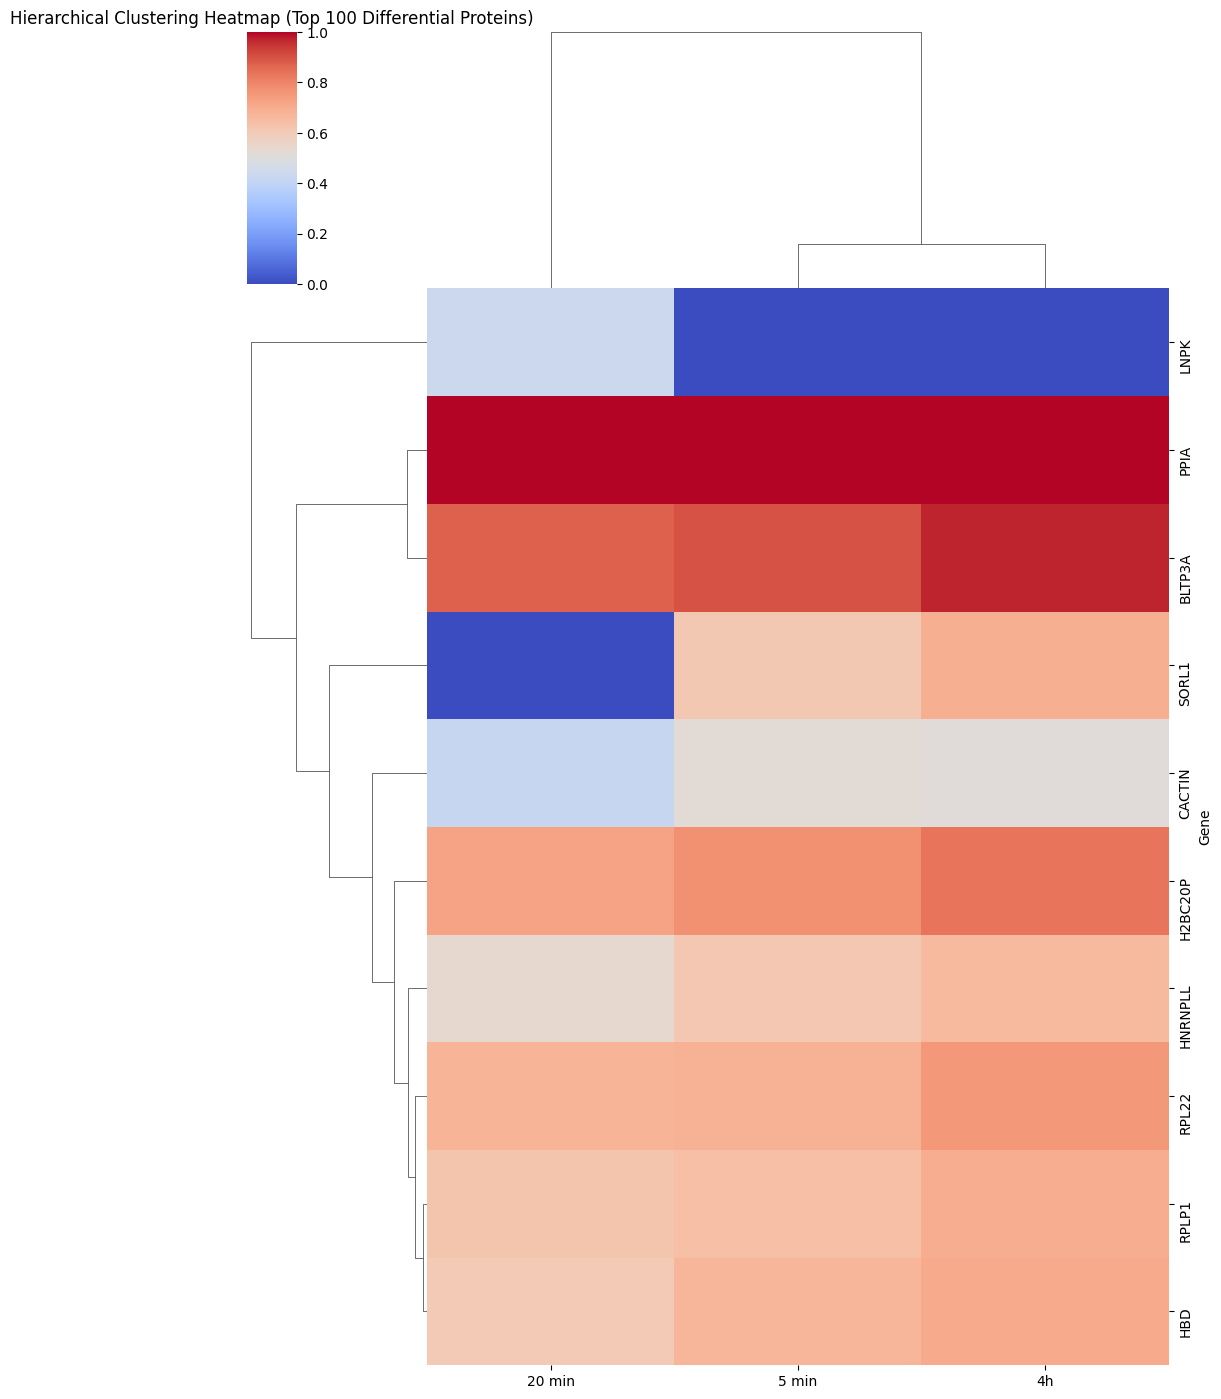

In [119]:
# Clip extreme values
zscore_df = zscore_df.clip(lower=-5, upper=5)

# Select the top 100 most differentially expressed proteins
top_proteins = zscore_df.std(axis=1).sort_values(ascending=False).head(100).index
zscore_top_df = zscore_df.loc[top_proteins]

# Find the optimal k value
scores = {}
for k in range(2, 9):
    model = KMeans(n_clusters=k, random_state=0).fit(zscore_top_df)
    scores[k] = silhouette_score(zscore_top_df, model.labels_)
best_k = max(scores, key=scores.get)

# Plot hierarchical clustering heatmap (normalized rows)
sns.clustermap(zscore_top_df, cmap="coolwarm", standard_scale=1, method="ward", figsize=(10, 14))
plt.title("Hierarchical Clustering Heatmap (Top 100 Differential Proteins)")
plt.show()

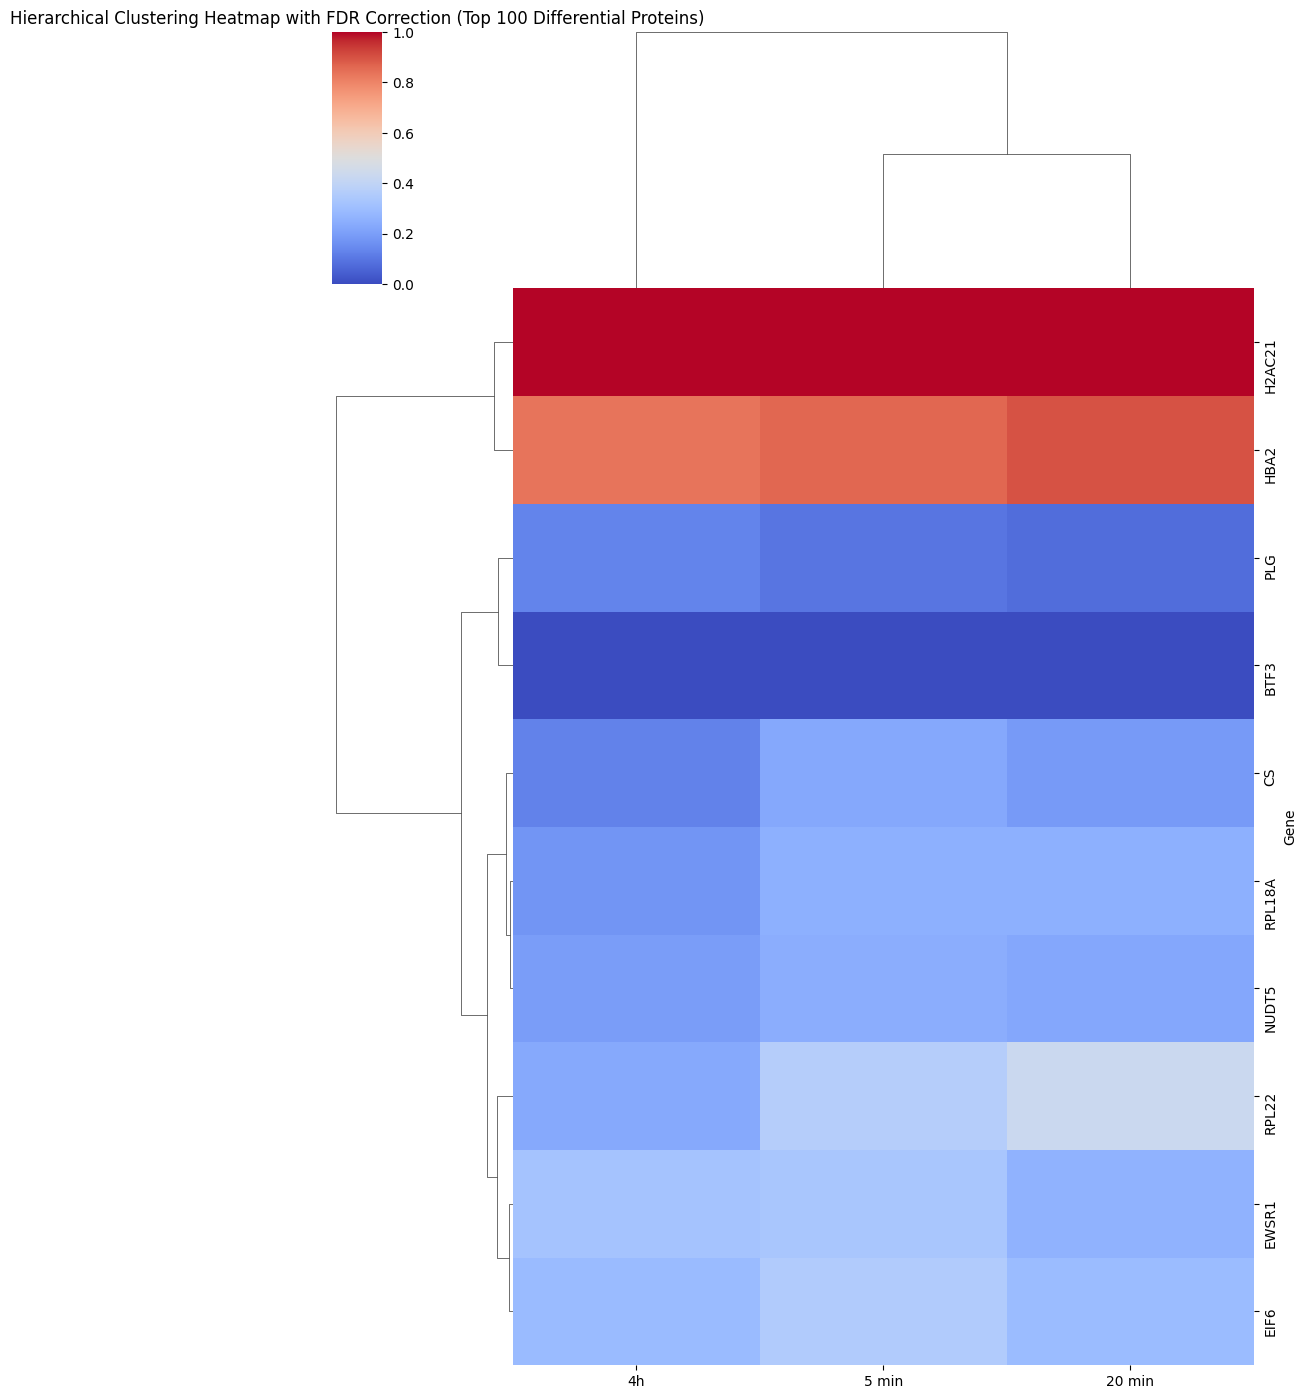

In [219]:
# Clip extreme values
zscore_fdr_df = zscore_fdr_df.clip(lower=-5, upper=5)

# Select the top 100 most differentially expressed proteins
top_proteins = zscore_fdr_df.std(axis=1).sort_values(ascending=False).head(100).index
zscore_top_df = zscore_fdr_df.loc[top_proteins]

# Find the optimal k value
scores = {}
for k in range(2, 9):
    model = KMeans(n_clusters=k, random_state=0).fit(zscore_top_df)
    scores[k] = silhouette_score(zscore_top_df, model.labels_)
best_k = max(scores, key=scores.get)

# Plot hierarchical clustering heatmap (normalized rows)
sns.clustermap(zscore_top_df, cmap="coolwarm", standard_scale=1, method="ward", figsize=(10, 14))
plt.title("Hierarchical Clustering Heatmap with FDR Correction (Top 100 Differential Proteins)")
plt.show()

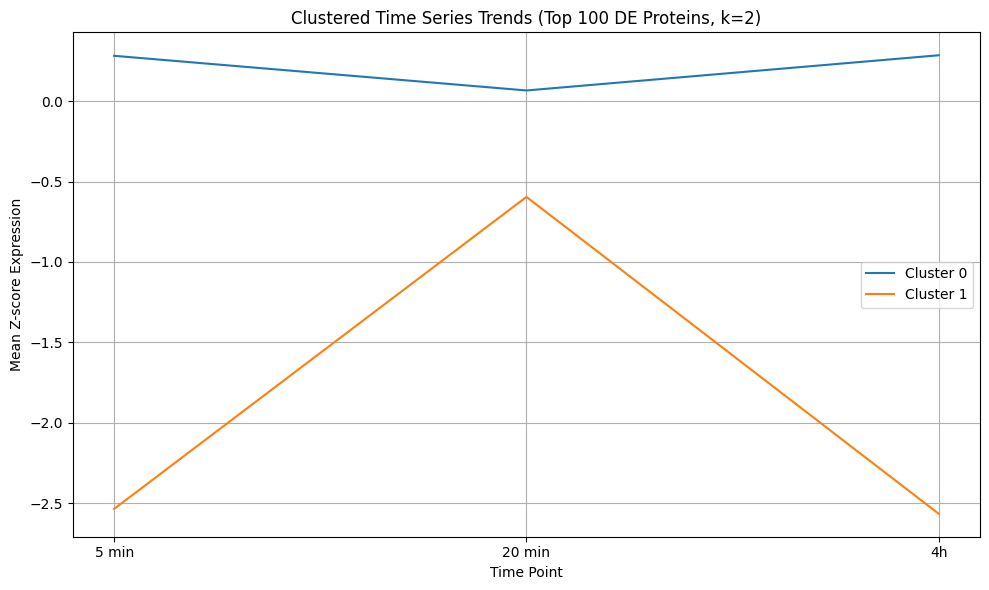

In [120]:
# Draw a K-means clustering line chart
kmeans = KMeans(n_clusters=best_k, random_state=0)
zscore_top_df["Cluster"] = kmeans.fit_predict(zscore_top_df)

plt.figure(figsize=(10, 6))
for cluster_id in range(best_k):
    cluster_data = zscore_top_df[zscore_top_df["Cluster"] == cluster_id].drop("Cluster", axis=1)
    cluster_mean = cluster_data.mean(axis=0)
    plt.plot(cluster_mean.index, cluster_mean.values, label=f"Cluster {cluster_id}")

plt.xlabel("Time Point")
plt.ylabel("Mean Z-score Expression")
plt.title(f"Clustered Time Series Trends (Top 100 DE Proteins, k={best_k})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

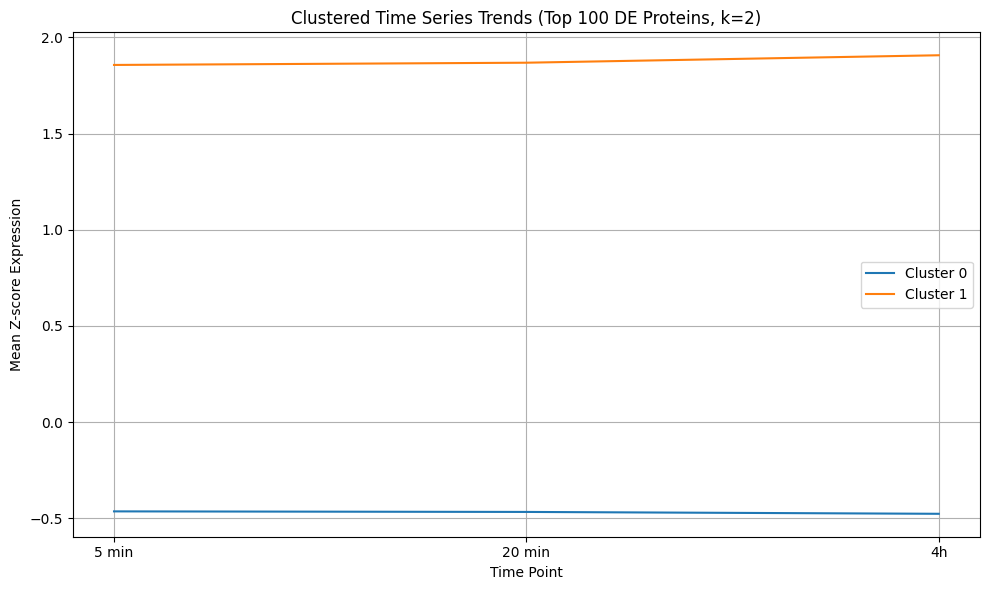

In [220]:
# Draw a K-means clustering line chart
kmeans = KMeans(n_clusters=best_k, random_state=0)
zscore_top_df["Cluster"] = kmeans.fit_predict(zscore_top_df)

plt.figure(figsize=(10, 6))
for cluster_id in range(best_k):
    cluster_data = zscore_top_df[zscore_top_df["Cluster"] == cluster_id].drop("Cluster", axis=1)
    cluster_mean = cluster_data.mean(axis=0)
    plt.plot(cluster_mean.index, cluster_mean.values, label=f"Cluster {cluster_id}")

plt.xlabel("Time Point")
plt.ylabel("Mean Z-score Expression")
plt.title(f"Clustered Time Series Trends (Top 100 DE Proteins, k={best_k})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cluster Enrichment Analysis

In [121]:
# ========= Cluster Enrichment Analysis =========
# Perform KEGG enrichment analysis for each cluster
cluster_results = {}
for cluster_id in zscore_top_df["Cluster"].unique():
    gene_list = zscore_top_df[zscore_top_df["Cluster"] == cluster_id].index.tolist()
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets="KEGG_2021_Human",
        organism="Human",
        outdir=None,
        cutoff=0.5
    )
    cluster_results[cluster_id] = enr.results[["Term", "Adjusted P-value", "Overlap", "Genes"]].sort_values("Adjusted P-value")

In [122]:
# Display the top 5 for each cluster enrichment analysis and save them
for cluster_id, df in cluster_results.items():
    print(f"\n=== Cluster {cluster_id} Top 5 KEGG Pathways ===")
    print(df.head(5))
    df.to_csv("./cluster_" + str(cluster_id) + "_results.csv")


=== Cluster 0 Top 5 KEGG Pathways ===
                  Term  Adjusted P-value Overlap        Genes
0             Ribosome          0.006458   2/158  RPLP1;RPL22
1  Coronavirus disease          0.006857   2/232  RPLP1;RPL22
2          Necroptosis          0.069330   1/159         PPIA

=== Cluster 1 Top 5 KEGG Pathways ===
Empty DataFrame
Columns: [Term, Adjusted P-value, Overlap, Genes]
Index: []


In [221]:
# Perform KEGG enrichment analysis for each cluster
cluster_results = {}
for cluster_id in zscore_top_df["Cluster"].unique():
    gene_list = zscore_top_df[zscore_top_df["Cluster"] == cluster_id].index.tolist()
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets="KEGG_2021_Human",
        organism="Human",
        outdir=None,
        cutoff=0.5
    )
    cluster_results[cluster_id] = enr.results[["Term", "Adjusted P-value", "Overlap", "Genes"]].sort_values("Adjusted P-value")

In [222]:
# Display the top 5 for each cluster enrichment analysis and save them
for cluster_id, df in cluster_results.items():
    print(f"\n=== Cluster {cluster_id} Top 5 KEGG Pathways ===")
    print(df.head(5))
    df.to_csv("./cluster_fdr_" + str(cluster_id) + "_results.csv")


=== Cluster 0 Top 5 KEGG Pathways ===
                                      Term  Adjusted P-value Overlap  \
0                                 Ribosome          0.018514   2/158   
1                      Coronavirus disease          0.019705   2/232   
2  Glyoxylate and dicarboxylate metabolism          0.032833    1/30   
3                Citrate cycle (TCA cycle)          0.032833    1/30   
4      Complement and coagulation cascades          0.066628    1/85   

          Genes  
0  RPL18A;RPL22  
1  RPL18A;RPL22  
2            CS  
3            CS  
4           PLG  

=== Cluster 1 Top 5 KEGG Pathways ===
                           Term  Adjusted P-value Overlap   Genes
0       African trypanosomiasis          0.014981    1/37    HBA2
1                       Malaria          0.014981    1/50    HBA2
2  Systemic lupus erythematosus          0.018811   1/135  H2AC21
3                   Necroptosis          0.018811   1/159  H2AC21
4                    Alcoholism          0.018811  